In [81]:
import sys
import os

import MetaTrader5 as mt5
import calendar
from datetime import datetime, date
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)


MODELS_FOLDER = 'C:/MetaQuotes/MQL5/Scripts/Kel/models_121x151/'
INPUT_SYMBOL = 'EURUSD'

IMAGE_LENGTH_M15 = 48
IMAGE_LENGTH_H1 = 48
IMAGE_LENGTH_H4 = 24
IMAGE_LENGTH_M5 = 24
IMAGE_LENGTH_D1 = 7

DAY = 2 * np.pi / (24*60*60)
WEEK = DAY / 7
YEAR = DAY / (365.2425)

THRESOLD_DIFF = 4
TARGET = 3

models = [tf.keras.models.load_model(MODELS_FOLDER + 'model_0'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_1'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_2'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_3'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_4'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_5'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_6'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_7'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_8'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_9'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_10'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_11'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_12'),
          tf.keras.models.load_model(MODELS_FOLDER + 'model_13')]


def self_diff(a: np.ndarray, shift=1):
    t = a - np.roll(a, -shift)
    return t


def build_features_one_timeframe(raw_data):
    # r = np.array(raw_data)
    # raw_data: old -> new
    d = np.flipud(raw_data)
    # d: new -> old
    ts = [datetime.fromtimestamp(x) for x in d[:, 5]]
    tt = [t.timetuple() for t in ts]
    a = np.zeros(shape=(122, len(d)), dtype=float)
# R000 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Open price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[0] = d[:, 0]
# R001 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[1] = d[:, 1]
# R002 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Low price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[2] = d[:, 2]
# R003 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[3] = d[:, 3]
# R004 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Max(Open, Close) price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[4] = np.maximum(a[0], a[3])
# R005 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Min(Open, Close) price, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[5] = np.minimum(a[0], a[3])
# R006 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close - Open, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[6] = a[3] - a[0]
# R007 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[7] = a[1] - a[2]
# R008 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Open, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[8] = a[1] - a[0]
# R009 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Close, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[9] = a[1] - a[3]
# R010 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[10] = a[3] - a[2]
# R011 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Open - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[11] = a[0] - a[2]
# R012 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Max(Open, Close), not including the current one, sorted by time desc, scaled based on max and min of that range
    a[12] = a[1] - a[4]
# R013 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Min(Open, Close), not including the current one, sorted by time desc, scaled based on max and min of that range
    a[13] = a[1] - a[5]
# R014 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Max(Open, Close) - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[14] = a[4] - a[2]
# R015 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Min(Open, Close) - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[15] = a[5] - a[2]
# R016 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Close + Open)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[16] = a[3] + a[0]
# R017 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[17] = a[1] + a[2]
# R018 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Open)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[18] = a[1] + a[0]
# R019 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Close)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[19] = a[1] + a[3]
# R020 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Open + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[20] = a[0] + a[2]
# R021 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Close + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[21] = a[3] + a[2]
# R022 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Max(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[22] = a[1] + a[4]
# R023 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Min(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[23] = a[1] + a[5]
# R024 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Low + Max(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[24] = a[4] + a[2]
# R025 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Low + Min(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[25] = a[5] + a[2]
# R026 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Volume, not including the current one, sorted by time desc, scaled based on max and min of that range
    a[26] = d[:, 4]
# R027 -> R053                        -    Diff from R001 -> R027, sorted by time desc, scaled based on max and min of that range
# R054 -> R080                        -    Diff from R028 -> R054, sorted by time desc, scaled based on max and min of that range
# R081 -> R107                        -    Diff from R055 -> R081, sorted by time desc, scaled based on max and min of that range
    for i in range(27):
        a[i + 27] = self_diff(a[i])
        a[i + 54] = self_diff(a[i + 27])
        a[i + 81] = self_diff(a[i + 54])
# R108 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Diff(Time), including the current one, sorted by time desc, scaled based on max and min of that range
    a[108] = self_diff(d[:, 5])
# R109 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day sin, including the current one, sorted by time desc, scaled based on -1-1
    a[109] = (np.sin(d[:, 5] * DAY) + 1) / 2
# R110 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day cos, including the current one, sorted by time desc, scaled based on -1-1
    a[110] = (np.cos(d[:, 5] * DAY) + 1) / 2
# R115 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Week sin, including the current one, sorted by time desc, scaled based on -1-1
    a[111] = (np.sin(d[:, 5] * WEEK) + 1) / 2
# R116 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Week cos, including the current one, sorted by time desc, scaled based on -1-1
    a[112] = (np.cos(d[:, 5] * WEEK) + 1) / 2
# R119 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Year sin, including the current one, sorted by time desc, scaled based on -1-1
    a[113] = (np.sin(d[:, 5] * YEAR) + 1) / 2
# R120 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Year cos, including the current one, sorted by time desc, scaled based on -1-1
    a[114] = (np.cos(d[:, 5] * YEAR) + 1) / 2
# R111 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of year, including the current one, sorted by time desc, scaled based on 0-365
    a[115] = np.array([t.tm_yday for t in tt]) / 365
# R112 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of month, including the current one, sorted by time desc, scaled based on 0-30
    a[116] = np.array([t.tm_mday for t in tt]) / 30
# R113 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of month reversed, including the current one, sorted by time desc, scaled based on 0-30
    a[117] = np.array([calendar.monthrange(t.tm_year, t.tm_mon)[1]
                       for t in tt]) / 30 - a[111]
# R114 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of week, including the current one, sorted by time desc, scaled based on 0-6
    a[118] = np.array([t.tm_wday for t in tt]) / 6
# R117 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Hour of day, including the current one, sorted by time desc, scaled based on 0-23
    a[119] = np.array([t.tm_hour for t in tt]) / 23
# R118 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Minute of hour, including the current one, sorted by time desc, scaled based on 0-59
    a[120] = np.array([t.tm_min for t in tt]) / 59
    a[121] = d[:, 5]

    return a


def build_image(a, w):
    return np.concatenate(([np.interp(x, (x.min(), x.max()), (0, 1)) for x in a[:109, :w]], a[109:, :w]))

#     M15    H1     H4     M5     D1
# ----50-----50-----20-----20-----10



In [40]:

def con_predict(raw_data_m5, raw_data_m15, raw_data_h1, raw_data_h4, raw_data_d1):

    features_m5 = build_features_one_timeframe(raw_data_m5)
    features_m15 = build_features_one_timeframe(raw_data_m15)
    features_h1 = build_features_one_timeframe(raw_data_h1)
    features_h4 = build_features_one_timeframe(raw_data_h4)
    features_d1 = build_features_one_timeframe(raw_data_d1)

    im_m15 = build_image(features_m15, IMAGE_LENGTH_M15)
    im_m5 = build_image(features_m5, IMAGE_LENGTH_M5)
    im_h1 = build_image(features_h1, IMAGE_LENGTH_H1)
    im_h4 = build_image(features_h4, IMAGE_LENGTH_H4)
    im_d1 = build_image(features_d1, IMAGE_LENGTH_D1)
    test_image = np.hstack((im_m15, im_h1, im_h4, im_d1, im_m5))


    b_test_im = tf.constant([test_image])
    preds = np.array([np.argmax(models[0].predict(b_test_im), axis=-1),
                        np.argmax(models[1].predict(b_test_im), axis=-1),
                        np.argmax(models[2].predict(b_test_im), axis=-1),
                        np.argmax(models[3].predict(b_test_im), axis=-1),
                        np.argmax(models[4].predict(b_test_im), axis=-1),
                        np.argmax(models[5].predict(b_test_im), axis=-1),
                        np.argmax(models[6].predict(b_test_im), axis=-1),
                        np.argmax(models[7].predict(b_test_im), axis=-1),
                        np.argmax(models[8].predict(b_test_im), axis=-1),
                        np.argmax(models[9].predict(b_test_im), axis=-1),
                        np.argmax(models[10].predict(b_test_im), axis=-1),
                        np.argmax(models[11].predict(b_test_im), axis=-1),
                        np.argmax(models[12].predict(b_test_im), axis=-1),
                        np.argmax(models[13].predict(b_test_im), axis=-1)])

    pred_buy = preds.flat[7:].sum()
    pred_sell = preds.flat[:7].sum()

    buy_condition = (pred_buy > pred_sell +
                        THRESOLD_DIFF) & (pred_buy >= TARGET)

    if (buy_condition):
        return 1, str(raw_data_m5[-1,5]), str(raw_data_m15[-1,5]), str(raw_data_h1[-1,5]), str(raw_data_h4[-1,5]), str(raw_data_d1[-1,5])
        # return 1, str(datetime.fromtimestamp(raw_data_m15[0,5])) + " " + str(datetime.fromtimestamp(raw_data_m15[-1,5]))

    return 0, str(raw_data_m5[-1,5]), str(raw_data_m15[-1,5]), str(raw_data_h1[-1,5]), str(raw_data_h4[-1,5]), str(raw_data_d1[-1,5])
    # return 0, str(datetime.fromtimestamp(raw_data_m15[0,5])) + " " + str(datetime.fromtimestamp(raw_data_m15[-1,5]))



In [42]:

from datetime import datetime
import MetaTrader5 as mt5

IMAGE_LENGTH_M15 = 48
IMAGE_LENGTH_H1 = 48
IMAGE_LENGTH_H4 = 24
IMAGE_LENGTH_M5 = 24
IMAGE_LENGTH_D1 = 7


INPUT_STARTDATE = datetime(2020, 7, 27, 22,59)
INPUT_SYMBOL = 'EURUSD'


mt5.initialize()

raw_data_m5 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_M5, datetime(2020, 7, 27, 22,55), IMAGE_LENGTH_M5 + 5)
raw_data_m15 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_M15, datetime(2020, 7, 27, 22,45), IMAGE_LENGTH_M15 + 5)
raw_data_h1 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_H1, datetime(2020, 7, 27, 22,0), IMAGE_LENGTH_H1 + 5)
raw_data_h4 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_H4, datetime(2020, 7, 27, 19,0), IMAGE_LENGTH_H4 + 5)
raw_data_d1 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_D1, datetime(2020, 7, 26, 23,0), IMAGE_LENGTH_D1 + 5)

mt5.shutdown()


True

In [72]:
print((datetime(2020, 7, 27, 22,55)-datetime(1970,1,1)).total_seconds())
print((datetime(2020, 7, 27, 22,45)-datetime(1970,1,1)).total_seconds())
print((datetime(2020, 7, 27, 22,0)-datetime(1970,1,1)).total_seconds())
print((datetime(2020, 7, 27, 19,0)-datetime(1970,1,1)).total_seconds())
print((datetime(2020, 7, 26, 23,0)-datetime(1970,1,1)).total_seconds())

1595890500.0
1595889900.0
1595887200.0
1595876400.0
1595804400.0


In [97]:
from datetime import timezone
print(datetime.fromtimestamp(raw_data_h1['time'][0], tz=timezone.utc), datetime.fromtimestamp(raw_data_h1['time'][-1], tz=timezone.utc))
print(datetime.fromtimestamp(raw_data_m15['time'][0], tz=timezone.utc), datetime.fromtimestamp(raw_data_m15['time'][-1], tz=timezone.utc))
print(raw_data_m15['time'][0], raw_data_m15['time'][-1])

2020-07-23 00:00:00+00:00 2020-07-27 04:00:00+00:00
2020-07-24 15:30:00+00:00 2020-07-27 04:30:00+00:00
1595604600 1595824200


In [43]:

def blah(x):
    rr = np.zeros(shape=(len(x), 6), dtype=float)
    rr[:,0] = x['open']
    rr[:,1] = x['high']
    rr[:,2] = x['low']
    rr[:,3] = x['close']
    rr[:,4] = x['tick_volume']
    rr[:,5] = x['time']
    return rr
    
r_m15 = blah(raw_data_m15)
r_m5 = blah(raw_data_m5)
r_h1 = blah(raw_data_h1)
r_h4 = blah(raw_data_h4)
r_d1 = blah(raw_data_d1)

In [49]:
# con_predict(r_m5,r_m15,r_h1,r_h4,r_d1)

print(str(r_m5[-1,5]), str(r_m15[-1,5]), str(r_h1[-1,5]), str(r_h4[-1,5]), str(r_d1[-1,5]))

# 2020.12.04 18:05:15.477	Core 1	2020.07.27 15:00:00   PREDICT RESULT 0 


# 1595861700 
# 1595861100 
# 1595858400 
# 1595836800 
# 1595548800

#  0 1595861700 1595861100 1595858400


1595861700.0 1595861100.0 1595858400.0 1595836800.0 1595548800.0


In [87]:
print((datetime(2020, 7, 27, 22,55)-datetime(1970,1,1,8)).total_seconds())
print((datetime(2020, 7, 27, 22,45)-datetime(1970,1,1,8)).total_seconds())
print((datetime(2020, 7, 27, 22,0)-datetime(1970,1,1,8)).total_seconds())
print((datetime(2020, 7, 27, 16,0)-datetime(1970,1,1,8)).total_seconds())
print((datetime(2020, 7, 24, 8,0)-datetime(1970,1,1,8)).total_seconds())
raw_data_d1[-1]['time']

1595861700.0
1595861100.0
1595858400.0
1595836800.0
1595548800.0


1595548800

In [84]:

def first_index_match(a, v, g):
    tp = v + 900 - g
    for i in range(len(a)):
        if (a[i] <= tp):
            return i
    return -1

GAP_M5 = 5 * 60
GAP_H1 = 3600
GAP_H4 = GAP_H1 * 4
GAP_D1 = GAP_H1 * 24

i_m5 = first_index_match(f_m5[121], 1595861100, GAP_M5)
i_h1 = first_index_match(f_h1[121], 1595861100, GAP_H1)
i_h4 = first_index_match(f_h4[121], 1595861100, GAP_H4)
i_d1 = first_index_match(f_d1[121], 1595861100, GAP_D1)

print(f_m5[121,i_m5])
print(1595861100)
print(f_h1[121,i_h1])
print(f_h4[121,i_h4])
print(f_d1[121,i_d1])


1595861700.0
1595861100
1595858400.0
1595836800.0
1595548800.0


In [53]:


b_test_im = tf.constant([test_images[5505]])
preds = np.array([np.argmax(models[0].predict(b_test_im), axis=-1),
                    np.argmax(models[1].predict(b_test_im), axis=-1),
                    np.argmax(models[2].predict(b_test_im), axis=-1),
                    np.argmax(models[3].predict(b_test_im), axis=-1),
                    np.argmax(models[4].predict(b_test_im), axis=-1),
                    np.argmax(models[5].predict(b_test_im), axis=-1),
                    np.argmax(models[6].predict(b_test_im), axis=-1),
                    np.argmax(models[7].predict(b_test_im), axis=-1),
                    np.argmax(models[8].predict(b_test_im), axis=-1),
                    np.argmax(models[9].predict(b_test_im), axis=-1),
                    np.argmax(models[10].predict(b_test_im), axis=-1),
                    np.argmax(models[11].predict(b_test_im), axis=-1),
                    np.argmax(models[12].predict(b_test_im), axis=-1),
                    np.argmax(models[13].predict(b_test_im), axis=-1)])

pred_buy = preds.flat[7:].sum()
pred_sell = preds.flat[:7].sum()

buy_condition = (pred_buy > pred_sell + THRESOLD_DIFF) & (pred_buy >= TARGET)

print(buy_condition, pred_buy, pred_sell)
print(preds)


False 1 2
[[1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [82]:
# rest, image = con_predict(r_m5,r_m15,r_h1,r_h4,r_d1)

f_m5 = build_features_one_timeframe(r_m5)
f_m15 = build_features_one_timeframe(r_m15)
f_h1 = build_features_one_timeframe(r_h1)
f_h4 = build_features_one_timeframe(r_h4)
f_d1 = build_features_one_timeframe(r_d1)

ig_m15 = build_image(f_m15, IMAGE_LENGTH_M15)
ig_m5 = build_image(f_m5, IMAGE_LENGTH_M5)
ig_h1 = build_image(f_h1, IMAGE_LENGTH_H1)
ig_h4 = build_image(f_h4, IMAGE_LENGTH_H4)
ig_d1 = build_image(f_d1, IMAGE_LENGTH_D1)
testig = np.hstack((ig_m15, ig_h1, ig_h4, ig_d1, ig_m5))



In [88]:
from numpy import load

dict_data = load('test_data.npz')
test_images = dict_data['images']
test_raw = dict_data['raw']
test_labels = dict_data['labels']


In [40]:
raw_data_m15[-1]['time']

1595826000

In [45]:

print(test_raw[0,5505], datetime.fromtimestamp(test_raw[0,5505]))



1595861100.0 2020-07-27 22:45:00


In [59]:
test_images[1245]



array([[0.38795181, 0.3253012 , 0.33975904, ..., 0.        , 0.33333333,
        0.15873016],
       [0.32394366, 0.33802817, 0.26478873, ..., 0.25581395, 0.01162791,
        0.06976744],
       [0.4747191 , 0.41573034, 0.40449438, ..., 0.04807692, 0.        ,
        0.20192308],
       ...,
       [0.83333333, 0.83333333, 0.83333333, ..., 0.83333333, 0.83333333,
        0.83333333],
       [0.30434783, 0.30434783, 0.30434783, ..., 0.26086957, 0.2173913 ,
        0.2173913 ],
       [0.76271186, 0.50847458, 0.25423729, ..., 0.        , 0.93220339,
        0.84745763]])

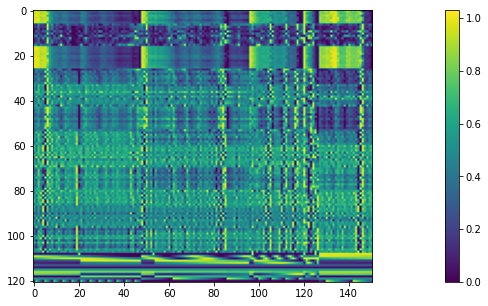

In [9]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.figure as mpfg
import mplfinance as mpf

plt.figure(figsize=(26, 5))
plt.imshow(test_images[5544])
plt.colorbar()
plt.grid(False)
plt.show()

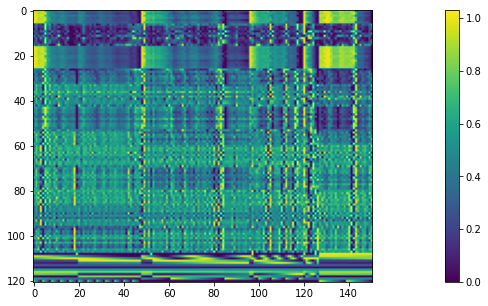

In [10]:

plt.figure(figsize=(26, 5))
plt.imshow(testig)
plt.colorbar()
plt.grid(False)
plt.show()

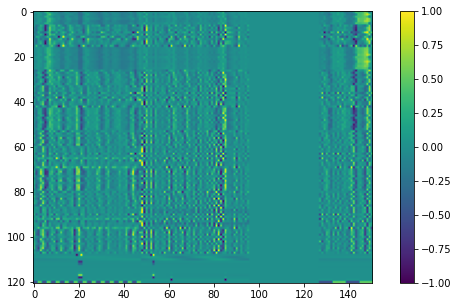

In [11]:

plt.figure(figsize=(10, 5))
plt.imshow(np.subtract(test_images[5543], testig))
plt.colorbar()
plt.grid(False)
plt.show()

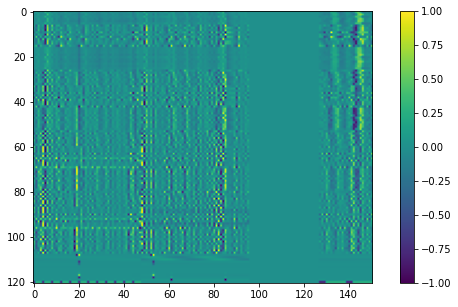

In [12]:

plt.figure(figsize=(10, 5))
plt.imshow(np.subtract(test_images[5544], testig))
plt.colorbar()
plt.grid(False)
plt.show()

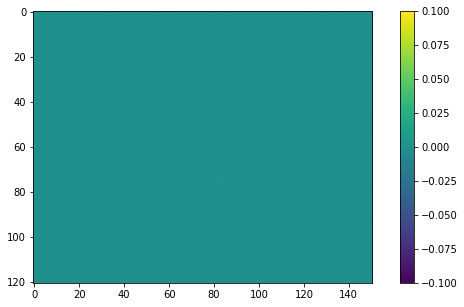

In [13]:

plt.figure(figsize=(10, 5))
plt.imshow(np.subtract(test_images[5545], testig))
plt.colorbar()
plt.grid(False)
plt.show()

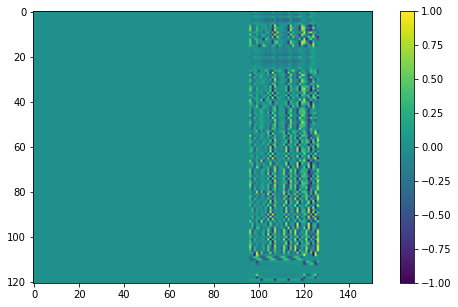

In [92]:

plt.figure(figsize=(10, 5))
# plt.imshow(np.subtract(test_images[5505], testig[:-1]))
plt.imshow(np.subtract(np.hstack((test_images[5505,:,:96],test_images[5500,:,96:-31],test_images[5450,:,-31:-24],test_images[5505,:,-24:])), testig[:-1]))
plt.colorbar()
plt.grid(False)
plt.show()